# Data exploration
In this section, we will explore which features of the dataset contribute to the car's price.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

C:\Users\deric\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Set data directory

data_dir = 'data'

In [4]:
!unzip craigslist-carstrucks-data.zip -d $data_dir

Archive:  craigslist-carstrucks-data.zip
  inflating: data/vehicles.csv       


In [ ]:
# Read in data

data = pd.read_csv(os.path.join(data_dir, 'vehicles.csv'))

data.head()

## Data clean-up
Drop rows whose year and price values are zero ornull. We will also drop columns that we will not be using for exploration.

In [6]:
df = data[data['price'] != 0]
df = df.dropna(subset=['year'])

df = df.drop(columns=['id', 'url', 'region', 'region_url', 'title_status', 'vin', 'image_url', 'description', 'county', 'lat', 'long', 'state'])

df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
0,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,manual,4wd,compact,hatchback,black,ut
2,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,automatic,4wd,NaN,NaN,white,ut
4,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,automatic,4wd,NaN,pickup,white,ut
5,13999,2009.0,ram,NaN,NaN,NaN,gas,120057.0,automatic,4wd,NaN,pickup,silver,ut
6,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,automatic,4wd,NaN,pickup,white,ut


### Data filtering
Take only the entries that were posted from 2015 to 2019 and plot the distribution of data to within these years.

In [7]:
years = [2015, 2016, 2017, 2018, 2019]

df = df[df['year'].isin(years)]

df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
2,46463,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,automatic,4wd,NaN,NaN,white,ut
4,49999,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,automatic,4wd,NaN,pickup,white,ut
6,34500,2017.0,ford,f-350,NaN,NaN,diesel,95484.0,automatic,4wd,NaN,pickup,white,ut
13,27999,2015.0,gmc,sierra,NaN,NaN,gas,73612.0,automatic,4wd,NaN,pickup,brown,ut
16,35500,2015.0,gmc,sierra,NaN,NaN,diesel,127515.0,automatic,4wd,NaN,pickup,black,ut


Save filtered dataset in case we need to load it in again in the future.

In [77]:
df.to_csv(os.path.join(data_dir, 'vehicles_filtered.csv'), index=False)

In [125]:
df = pd.read_csv(os.path.join(data_dir, 'vehicles_filtered.csv'))

126288


Text(0.5, 1.0, 'Entries per year')

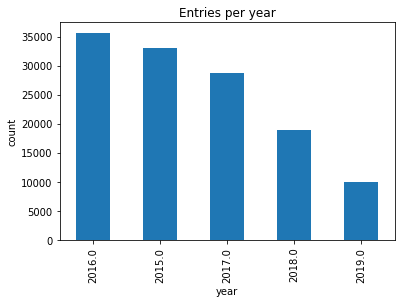

In [126]:
print(df.shape[0])
df['year'].value_counts().plot(kind='bar')
plt.xlabel('year')
plt.ylabel('count')
plt.title('Entries per year')

### Car model feature
The model feature requires additional clean-up. This is because unlike other features, the model column's exact text value can vary greatly depending on the poster's prerogative. For example, a car's actual model can ba 'civic' but the poster might opt to put in 'civic automatic' instead which is essentially the same category but, if unhandled, will result to its own separate category. This can be seen by simply viewing the raw model feature values.

In [75]:
df['model'].value_counts()

f-150                                                                3128
1500                                                                 2548
silverado 1500                                                       2201
2500                                                                 1355
altima                                                               1351
silverado                                                            1132
escape                                                               1110
equinox                                                              1014
fusion                                                               1006
tacoma                                                                993
grand cherokee                                                        976
explorer                                                              935
camry                                                                 922
malibu                                

In [76]:
model_counts = df['model'].value_counts()

model_counts = model_counts[model_counts < 50] # Estimate to show redundant categories

model_counts

patriot sport                                                        49
focus se hatchback 4d                                                49
tucson se sport utility                                              49
outback 2.5i limited                                                 49
Club Car Electric                                                    48
juke                                                                 48
romeo giulia                                                         48
elantra gt                                                           48
f150 4x4                                                             48
expedition max                                                       48
3-series                                                             48
a7                                                                   48
sportage lx sport utility 4d                                         48
sonic lt                                                        

Use containtment to normalize redundant model classes

In [3]:
import re
from sklearn.feature_extraction.text import CountVectorizer

token_pattern = r'(?!19|20\d{2})\b[a-zA-Z0-9-.]+'

def calculate_containment(answer, source, n):    
    match = re.search(token_pattern, source)
    
    if not match:
        return 0
    
    counts = CountVectorizer(ngram_range=(1,n),
                             token_pattern=token_pattern) # Exclude year in model
    
    ngram_array = counts.fit_transform([answer, source]).toarray()
    
    intersections = [min(c, ngram_array[1][i]) for i, c in enumerate(ngram_array[0])]
    
    source_sum = np.sum(ngram_array[0])
    
    containment = np.sum(intersections) / np.sum(ngram_array[0]) if source_sum > 0 else 0
    
    return containment

In [4]:
def clean_model_feature(df_to_clean):    
    # Account for '-' only filler for model feature value
    df_to_clean[df_to_clean['model'] == '-'] = np.nan
    
    df_to_clean.dropna(subset=['model'], inplace=True)
    
    model_word_count = []
    
    for i in range(len(df_to_clean)):
        model = df_to_clean.iloc[i]['model']
        model_word_count.append(len(model.split()))
    
    df_to_clean['model_word_count'] = model_word_count
    
    df_to_clean.sort_values(by='model_word_count', inplace=True)
    
    model_manufacturer_classes = {}
    
    print_every = 10000
    
    df_len = len(df_to_clean)
    
    new_models = []
    
    for i in range(df_len):
        if i % print_every == 0:
            print('Processing row {}/{}'.format(i + 1, df_len))
            
        if df_to_clean.iloc[i]['model_word_count'] < 1:
            new_models.append('')
            
            continue
        
        model = df_to_clean.iloc[i]['model'].lower().replace('-', '')
        
        manufacturer = df_to_clean.iloc[i]['manufacturer']
        
        if manufacturer not in model_manufacturer_classes:
            model_manufacturer_classes[manufacturer] = []
            
        model_classes = model_manufacturer_classes[manufacturer]
        
        match_model_class = None
        
        for model_class in model_classes:
            if model == model_class:
                match_model_class = model
                break
            
            model_class_len = len(model_class.split())
            
            containment = calculate_containment(model, model_class, model_class_len)
            
            model_len = len(re.findall(token_pattern, model))
            
            if model_len == 0:
                continue
            
            if containment >= model_class_len / model_len:
                match_model_class = model_class
                break
                
        if match_model_class is None:
            match_model_class = model
            model_classes.append(model)
        
        new_models.append(match_model_class)
        
    df_to_clean['model'] = new_models

In [196]:
clean_model_df = df.copy()

clean_model_feature(clean_model_df)

clean_model_df = clean_model_df.drop(columns=['model_word_count'])

clean_model_df

Processing row 1/125685
Processing row 10001/125685
Processing row 20001/125685
Processing row 30001/125685
Processing row 40001/125685
Processing row 50001/125685
Processing row 60001/125685
Processing row 70001/125685
Processing row 80001/125685
Processing row 90001/125685
Processing row 100001/125685
Processing row 110001/125685
Processing row 120001/125685


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
63119,9995.0,2015.0,dodge,dart,NaN,NaN,gas,94030.0,automatic,fwd,NaN,sedan,NaN,ks
94628,27245.0,2018.0,ford,f150,NaN,NaN,other,24692.0,automatic,4wd,NaN,pickup,white,ny
94626,16555.0,2016.0,mercedes-benz,c,excellent,4 cylinders,gas,48702.0,automatic,4wd,compact,sedan,black,ny
94625,39895.0,2016.0,mercedes-benz,gleclass,NaN,NaN,gas,51501.0,automatic,NaN,NaN,SUV,silver,ny
46876,1500.0,2016.0,ford,fusion,like new,4 cylinders,gas,NaN,automatic,fwd,full-size,sedan,red,fl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120563,14999.0,2017.0,ford,transit,NaN,6 cylinders,NaN,97007.0,automatic,rwd,NaN,van,white,tx
17644,34770.0,2015.0,toyota,tundra,NaN,8 cylinders,NaN,45215.0,automatic,4wd,NaN,pickup,red,az
84327,22900.0,2018.0,ford,transit,NaN,NaN,NaN,12118.0,automatic,rwd,NaN,NaN,NaN,nc
28748,24997.0,2018.0,chevrolet,silverado,NaN,NaN,gas,23380.0,automatic,NaN,NaN,pickup,white,ca


Save cleaned dataframe for loading later.

In [197]:
clean_model_df.to_csv(os.path.join(data_dir, 'vehicles_model.csv'), index=False)

In [198]:
model_counts = clean_model_df['model'].value_counts()

remove_threshold = 50

trimmed_df = clean_model_df[clean_df['model'].isin(model_counts[model_counts > remove_threshold].index)]

trimmed_df.to_csv(os.path.join(data_dir, 'vehicles_trimmed.csv'), index=False)

Delete _vehicles.csv_ since we don't longer need it.

In [ ]:
!rm $data_dir/vehicles.csv

In [189]:
clean_df = pd.read_csv(os.path.join(data_dir, 'vehicles_clean.csv'))

clean_df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
0,9995.0,2015.0,dodge,dart,NaN,NaN,gas,94030.0,automatic,fwd,NaN,sedan,NaN,ks
1,27245.0,2018.0,ford,f150,NaN,NaN,other,24692.0,automatic,4wd,NaN,pickup,white,ny
2,16555.0,2016.0,mercedes-benz,c,excellent,4 cylinders,gas,48702.0,automatic,4wd,compact,sedan,black,ny
3,39895.0,2016.0,mercedes-benz,gleclass,NaN,NaN,gas,51501.0,automatic,NaN,NaN,SUV,silver,ny
4,1500.0,2016.0,ford,fusion,like new,4 cylinders,gas,NaN,automatic,fwd,full-size,sedan,red,fl


## Feature-price correlation
Here we explore how each feature is correlated, if at all, to the car's _price_.

Features to be explored are:
1. manufacturer
2. odometer
3. transmission
4. paint_color
5. fuel
6. type
7. drive
8. size
9. state

In [4]:
trimmed_df = pd.read_csv(os.path.join(data_dir, 'vehicles_trimmed.csv'))

In [85]:
def plot_correlation(df, feature, fig_size=(6.4, 4.8), ylim=(0, 1e5)):
    plt.figure(figsize=fig_size)

    sb.boxplot(data = df, x = feature, y = 'price')
    plt.ylabel('price (USD)')
    plt.ylim(ylim)
    plt.xticks(rotation=45)

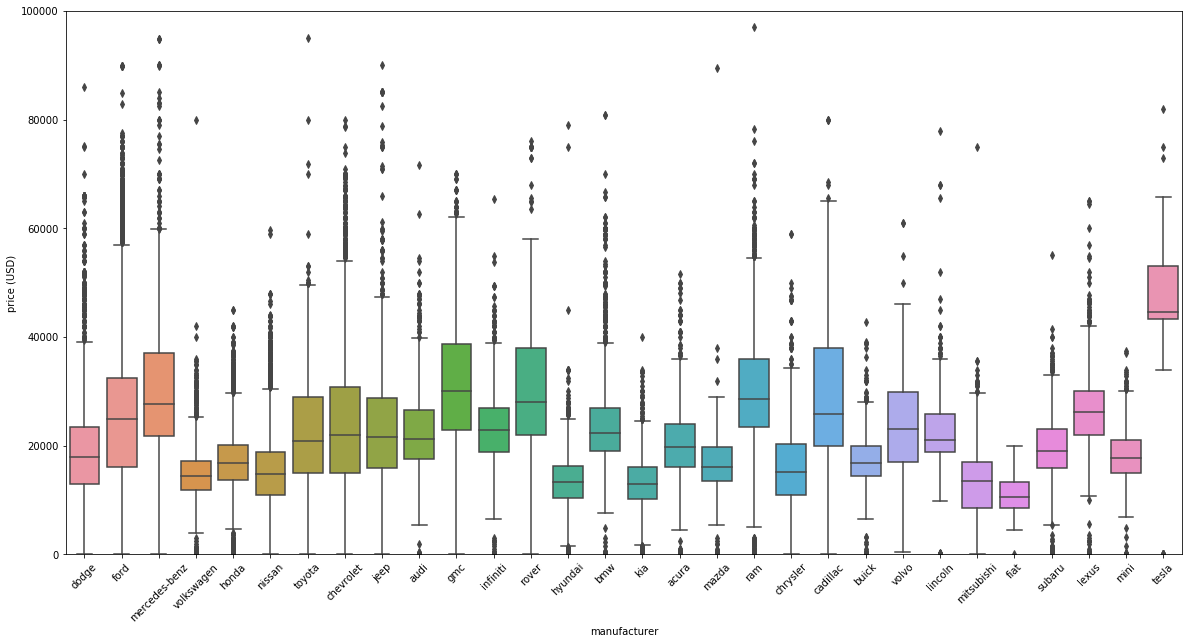

In [86]:
plot_correlation(trimmed_df, 'manufacturer', fig_size=(20,10))

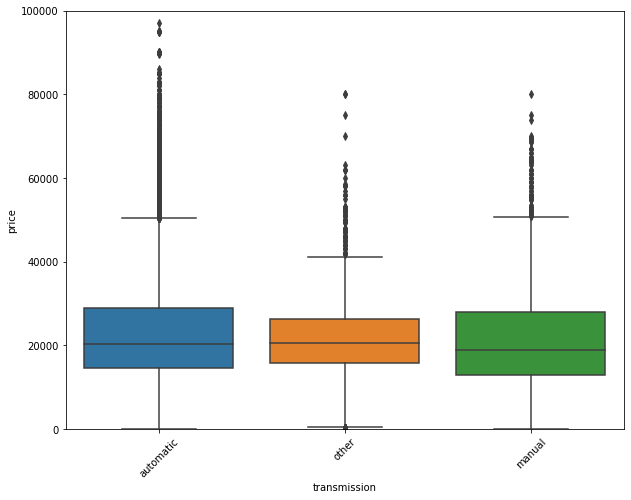

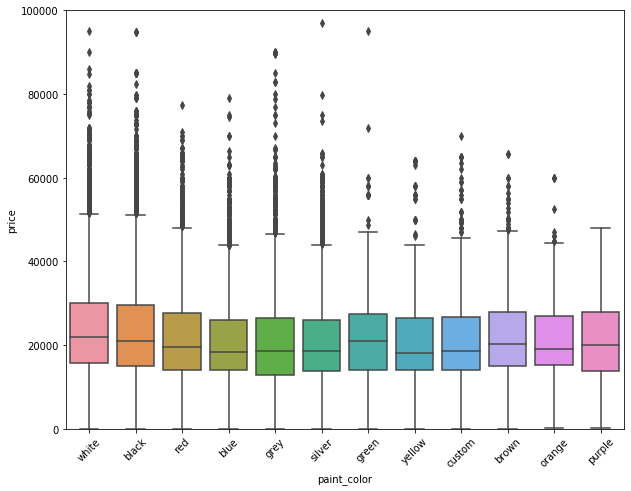

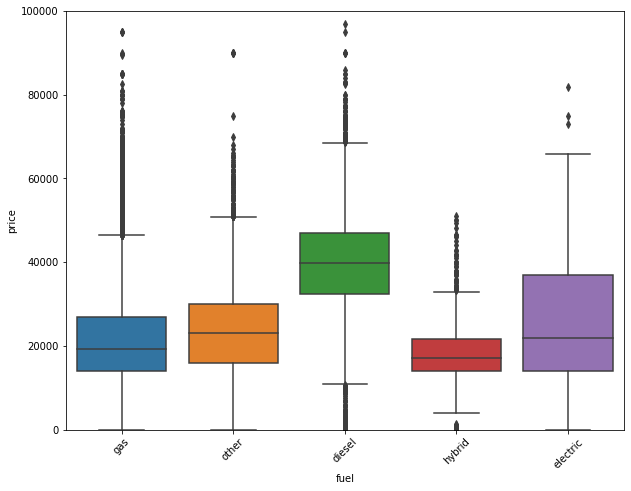

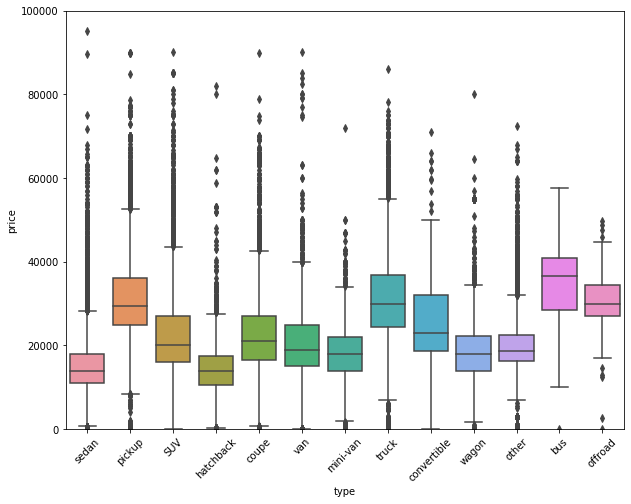

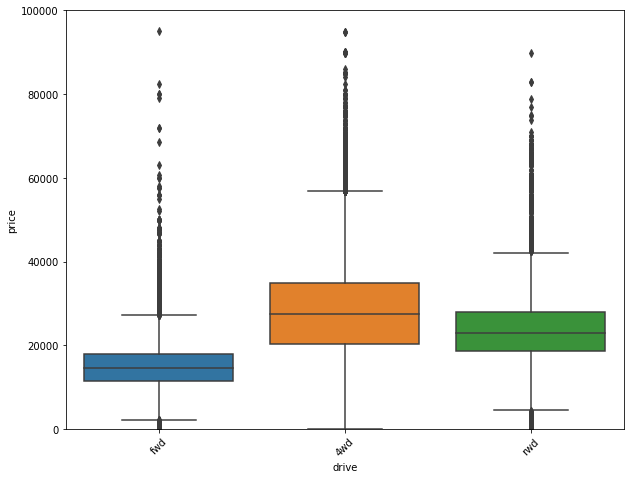

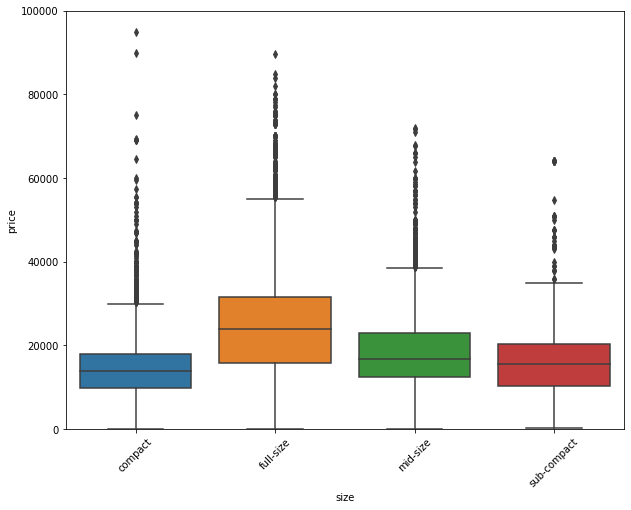

In [65]:
correlation_features = ['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size']

for feature in correlation_features:
    plot_correlation(trimmed_df, feature, fig_size=(10, 7.7))

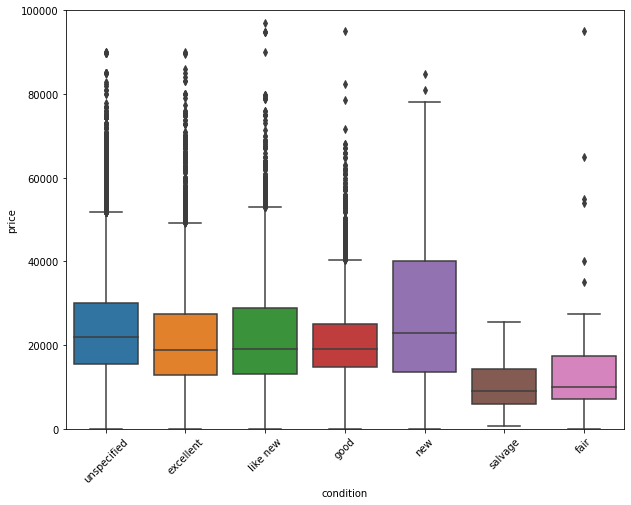

In [63]:
condition_df = trimmed_df.copy()
condition_df['condition'].fillna('unspecified', inplace=True)

plot_correlation(condition_df, 'condition', fig_size=(10, 7.7))

(array([     0.,  25000.,  50000.,  75000., 100000., 125000., 150000.,
        175000., 200000.]),
 <a list of 9 Text xticklabel objects>)

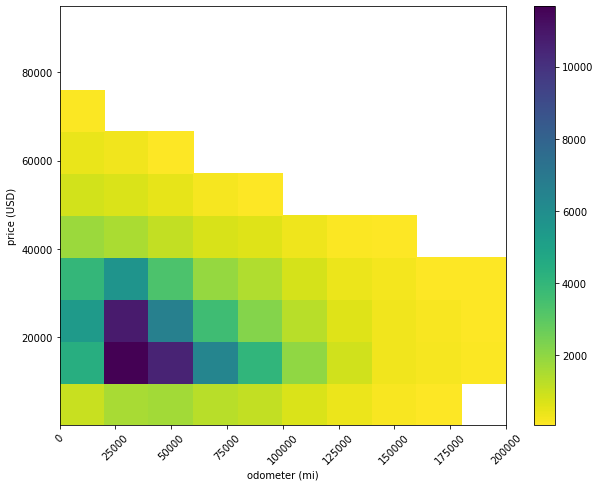

In [101]:
odometer_df = trimmed_df[trimmed_df['price'] <= 1e5]
odometer_df = odometer_df[odometer_df['odometer'] <= 2e5]

plt.figure(figsize=(10, 7.7))
plt.hist2d(data=odometer_df, x='odometer', y='price', cmap = 'viridis_r', cmin=50)
plt.colorbar();
plt.ylabel('price (USD)')
plt.xlabel('odometer (mi)')
plt.xticks(rotation=45)

In [69]:
cut_df = trimmed_df[trimmed_df['price'] <= 1e5]
cut_df = cut_df[cut_df['odometer'] <= 2e5]

cut_df.to_csv(os.path.join(data_dir, 'vehicles_cut.csv'), index=False)

## Categorical features distribution
Here we explore how balanced or imbalanced the distribution of our categorical features' classes are.

Features to be explored are:
1. model
2. manufacturer
3. transmission
4. paint_color
5. fuel
6. type
7. drive
8. size
9. type

In [39]:
import math

def plot_class_distribution(df, feature, fig_size=(6.4, 4.8), others_threshold=10, kind='bar'):
    counts = df[feature].value_counts(ascending=True)

    mask = counts[counts < others_threshold]
    others_count = mask.sum()

    if others_count > 0:
        counts = counts[counts >= others_threshold]
        counts = counts.sort_values(0)
        counts.loc['others'] = others_count

    plt.figure(figsize=fig_size)
    plt.ylabel(feature)
    plt.xlabel('count')
    plt.title('{} class distribution'.format(feature.capitalize()))

    counts.plot(kind=kind)

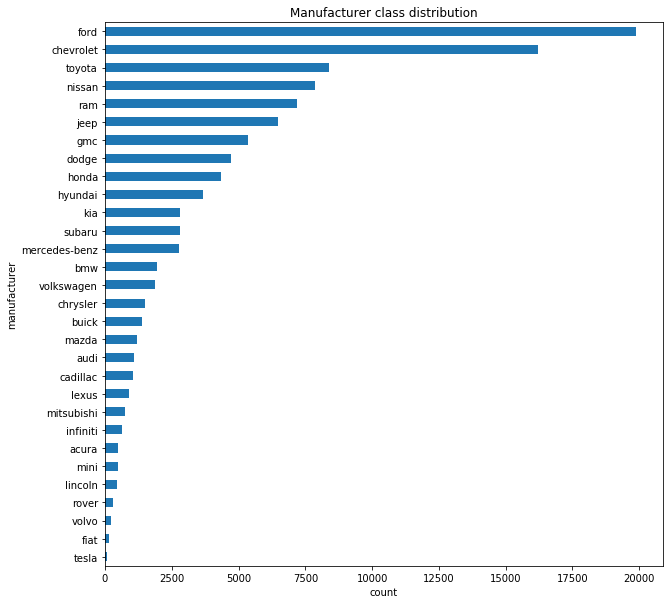

In [70]:
plot_class_distribution(cut_df, 'manufacturer', fig_size=(10, 10), others_threshold=50, kind='barh')

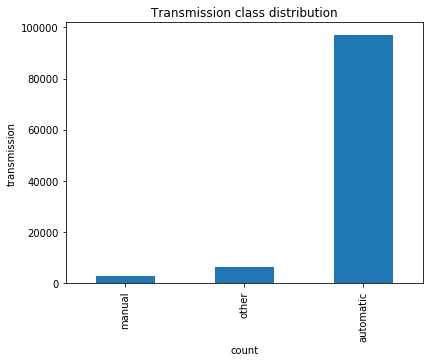

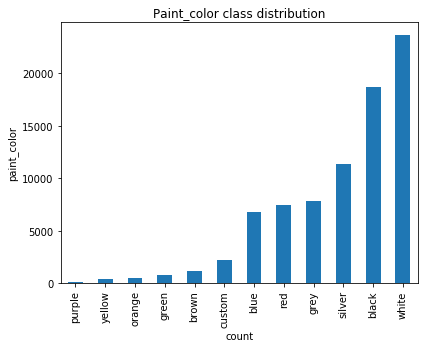

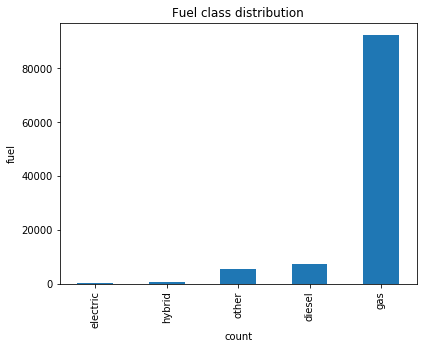

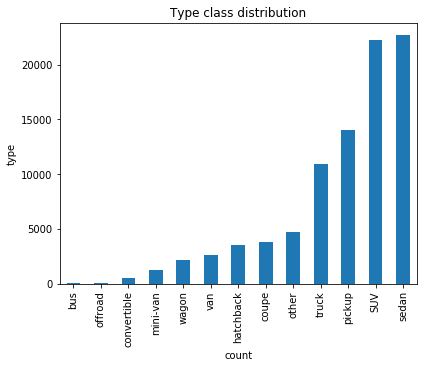

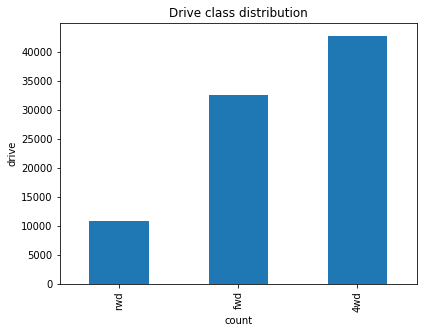

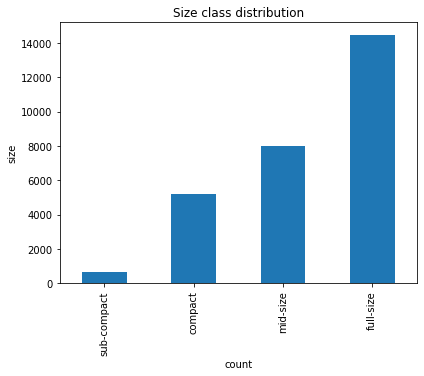

In [71]:
distribution_features = ['transmission', 'paint_color', 'fuel', 'type', 'drive', 'size']

for feature in distribution_features:
    plot_class_distribution(cut_df, feature)

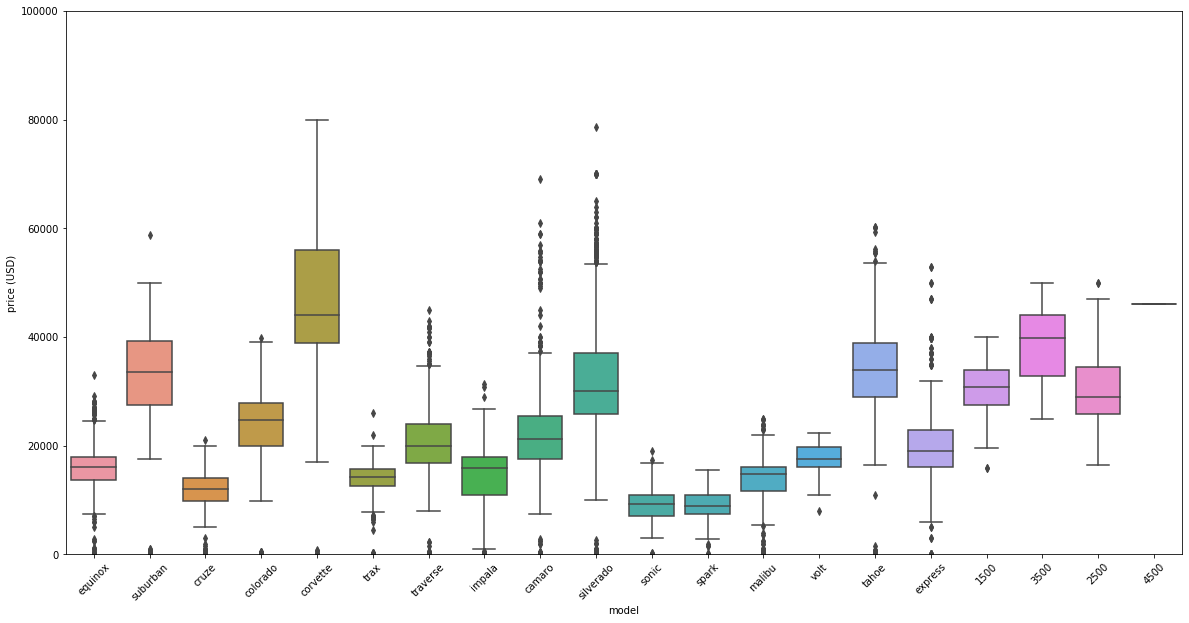

In [97]:
chevrolet_df = cut_df[cut_df['manufacturer'] == 'chevrolet']

plot_correlation(chevrolet_df, 'model', fig_size=(20,10))

(array([-25000.,      0.,  25000.,  50000.,  75000., 100000., 125000.,
        150000., 175000., 200000.]),
 <a list of 10 Text xticklabel objects>)

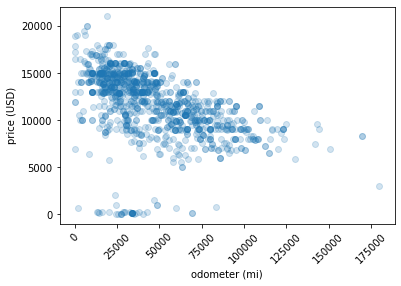

In [104]:
cruze_df = chevrolet_df[chevrolet_df['model'] == 'cruze']

plt.scatter(data=cruze_df, x='odometer', y='price', alpha=1/5)
plt.ylabel('price (USD)')
plt.xlabel('odometer (mi)')
plt.xticks(rotation=45)

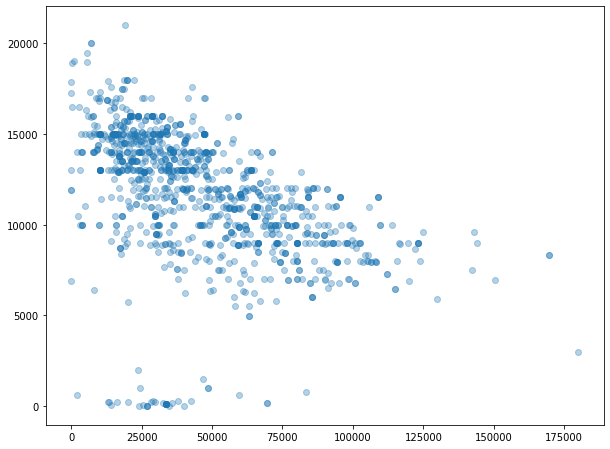

In [119]:
plt.figure(figsize=(10,7.7))
plt.scatter(data=cruze_df, x='odometer', y='price', alpha=1/3)